In [1]:
!nvidia-smi -L || true
!pip install -U pandas
!pip install  -U numpy
!pip install --upgrade accelerate
!pip -q install --upgrade  evaluate datasets scikit-learn torchmetrics  matplotlib pandas seaborn sentencepiece

GPU 0: NVIDIA L4 (UUID: GPU-5a107500-41b6-c689-7dc1-80941a99dc4b)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 158.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 138.4 MB/s eta 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 159.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 148.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 58.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 w

In [1]:
import numpy as np
import pandas as pd


print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")

numpy version: 2.3.3
pandas version: 2.3.3


In [2]:
# =========================================================
# 0) SETUP (GPU + Libraries)  — transformers 4.56.2
# =========================================================


import os, math, json, gc, time, random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F

import transformers
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
)

from datasets import load_dataset
from sklearn.metrics import f1_score
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns
from rich import print as rprint

print("Transformers version:", transformers.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)
print(device)


Transformers version: 4.56.2
cuda


In [3]:
# ===========================================
# 1) DATA: GoEmotions (28 labels incl. neutral)
#    We'll use the original 28-label configuration.
# ===========================================
# HF dataset name: "go_emotions"
# Configs: "simplified", "raw" etc. We select "raw" (multi-label) and keep 'neutral'.
ds = load_dataset("google-research-datasets/go_emotions", "simplified")  # train/validation/test splits
ds["train"][:5]



README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

{'text': ["My favourite food is anything I didn't have to cook myself.",
  'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
  'WHY THE FUCK IS BAYLESS ISOING',
  'To make her feel threatened',
  'Dirty Southern Wankers'],
 'labels': [[27], [27], [2], [14], [3]],
 'id': ['eebbqej', 'ed00q6i', 'eezlygj', 'ed7ypvh', 'ed0bdzj']}

In [4]:
label_list = ds["train"].features["labels"].feature.names  # 28 labels (incl. neutral)
num_labels = len(label_list)
print(f"Labels ({num_labels}): {label_list}")

# Remove dropped examples if any and keep text/labels
def to_multihot(example):
    # HF provides 'labels' as list of indices; convert to fixed-size multi-hot
    mhot = np.zeros(num_labels, dtype=np.float32)
    for idx in example["labels"]:
        mhot[idx] = 1.0
    return {"text": example["text"], "label_mhot": mhot.tolist()}

ds = ds.map(to_multihot, remove_columns=[c for c in ds["train"].column_names if c not in ["text","labels"]])
ds = ds.remove_columns(["labels"])

# Choose a strong encoder backbone (RoBERTa base)
BACKBONE = "roberta-base"
BACKBONE = "microsoft/deberta-v3-base"
# BACKBONE = "microsoft/deberta-v2-xlarge"

tokenizer = AutoTokenizer.from_pretrained(BACKBONE, use_fast=True)

MAX_LEN = 128
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=MAX_LEN)

tokenized = ds.map(tokenize_fn, batched=True)
tokenized = tokenized.rename_column("label_mhot", "labels")
tokenized.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Collator (dynamic padding)
collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)  # better for tensor cores

Labels (28): ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
# ===========================================
# 2) METRICS (multi-label): Micro-F1, Macro-F1, Accuracy
#    We compute on thresholded predictions later; Trainer needs a function too.
# ===========================================
def multilabel_metrics(y_true: np.ndarray, y_prob: np.ndarray, thresholds=None) -> Dict[str, float]:
    """
    y_true: (N, C) in {0,1}
    y_prob: (N, C) in [0,1]
    thresholds: None or (C,) array of label-wise thresholds; default 0.5
    """
    if thresholds is None:
        thr = np.full(y_prob.shape[1], 0.5, dtype=np.float32)
    else:
        thr = thresholds
    y_pred = (y_prob >= thr[None, :]).astype(int)

    micro_f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # "Accuracy" for multi-label is subset-accuracy (exact match); often low. Report but don't over-index on it.
    exact_acc = (y_true == y_pred).all(axis=1).mean()

    return {"micro_f1": micro_f1, "macro_f1": macro_f1, "accuracy": exact_acc}

def tune_thresholds(y_true: np.ndarray, y_prob: np.ndarray) -> np.ndarray:
    """
    Per-label threshold tuning on dev set to maximize F1 (macro focus).
    Simple sweep from 0.05 to 0.95; can be replaced by golden-section search if needed.
    """
    C = y_true.shape[1]
    best_thr = np.zeros(C, dtype=np.float32)
    for c in range(C):
        t_best, f_best = 0.5, -1.0
        for t in np.linspace(0.05, 0.95, 19):
            pred_c = (y_prob[:, c] >= t).astype(int)
            f1_c = f1_score(y_true[:, c], pred_c, zero_division=0)
            if f1_c > f_best:
                f_best, t_best = f1_c, t
        best_thr[c] = t_best
    return best_thr


In [6]:
# ===========================================
# 3) BASELINE MODEL: RoBERTa-base (multi-label)
# ===========================================
from transformers import AutoModelForSequenceClassification

ROBERTA_DIR = "/content/roberta_goemo"
KAN_DIR     = "/content/kan_roberta_goemo"

TRAIN_ROBERTA = True   # toggle
TRAIN_KAN     = True   # toggle

roberta_model = AutoModelForSequenceClassification.from_pretrained(
    BACKBONE,
    num_labels=num_labels,
    problem_type="multi_label_classification",
)
roberta_model.config.gradient_checkpointing = True
roberta_model.to(device)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [7]:
# ===========================================  Variant 1 ====================
# 4) KAN-STYLE HEAD: Kolmogorov–Arnold-inspired functional layer
#    We keep the RoBERTa encoder and swap the classifier head with a KAN-like head:
#    - CLS embedding (or mean-pool) -> per-dimension RBF expansions (1D basis funcs)
#    - Linear mixing -> labels. This approximates K–A decomposition with per-dim φ(g(x_i)).
# ===========================================

class RBF1D(nn.Module):
    """
    1D radial-basis expansion per feature dimension:
    For each feature x_d, compute K Gaussians: exp(- (x_d - mu_k)^2 / (2*sig_k^2) )
    """
    def __init__(self, num_features: int, K: int = 16):
        super().__init__()
        self.num_features = num_features
        self.K = K
        # centers and log_sigmas per feature-dim and per basis
        self.mu = nn.Parameter(torch.randn(num_features, K) * 0.5)
        self.log_sigma = nn.Parameter(torch.zeros(num_features, K))  # start ~1.0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, D)
        # output: (B, D*K) concatenated RBF responses per-dim
        B, D = x.shape
        x = x.unsqueeze(-1)                    # (B, D, 1)
        mu = self.mu.unsqueeze(0)             # (1, D, K)
        sig = torch.exp(self.log_sigma).unsqueeze(0) + 1e-6  # (1, D, K)
        z = torch.exp(-0.5 * ((x - mu) / sig)**2)            # (B, D, K)
        return z.view(B, D * self.K)

class KANHead(nn.Module):
    """
    KAN-like multilabel head:
     - Take a sentence embedding h (CLS or mean-pool).
     - Apply per-dim 1D RBF bank (approximating φ_d).
     - Linear mix across expanded dims -> labels (approximating outer sum).
    """
    def __init__(self, hidden_size: int, num_labels: int, K: int = 16, dropout=0.1, pool="cls"):
        super().__init__()
        self.pool = pool
        self.rbf = RBF1D(num_features=hidden_size, K=K)
        self.bn = nn.BatchNorm1d(hidden_size * K)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_size * K, num_labels)

    def forward(self, last_hidden_state, attention_mask):
        # pooling
        if self.pool == "cls":
            # assume first token is CLS
            h = last_hidden_state[:, 0]  # (B, H)
        else:
            # mean-pool masked tokens
            mask = attention_mask.unsqueeze(-1)  # (B, T, 1)
            h = (last_hidden_state * mask).sum(dim=1) / (mask.sum(dim=1).clamp(min=1e-6))
        z = self.rbf(h)
        z = self.bn(z)
        z = self.dropout(z)
        logits = self.out(z)
        return logits

class RobertaKANForMultiLabel(nn.Module):
    def __init__(self, backbone: str, num_labels: int, K=16, pool="cls", freeze_encoder=False):
        super().__init__()
        self.config = AutoConfig.from_pretrained(backbone)
        self.encoder = AutoModel.from_pretrained(backbone, add_pooling_layer=False)
        self.num_labels = num_labels
        self.head = KANHead(hidden_size=self.config.hidden_size, num_labels=num_labels, K=K, pool=pool)
        self.loss_fn = nn.BCEWithLogitsLoss()
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.head(out.last_hidden_state, attention_mask)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
        return {"loss": loss, "logits": logits}


In [12]:
from transformers import AutoModel, AutoConfig
import torch
import torch.nn as nn
import numpy as np

# ===========================================
# IMPROVED KAN-STYLE HEAD with multiple enhancements
# ===========================================

class RBF1D(nn.Module):
    """
    Improved 1D radial-basis expansion per feature dimension.
    - Better initialization with spread centers
    - Numerical stability improvements
    - Adaptive sigma parameters
    """
    def __init__(self, num_features: int, K: int = 16):
        super().__init__()
        self.num_features = num_features
        self.K = K

        # Better initialization: spread centers across expected input range
        # Assuming inputs are roughly normalized [-3, 3]
        centers = torch.linspace(-3, 3, K).unsqueeze(0).repeat(num_features, 1)
        self.mu = nn.Parameter(centers + torch.randn_like(centers) * 0.1)

        # Initialize sigma to cover the space between centers
        initial_sigma = 6.0 / K  # overlap between adjacent centers
        self.log_sigma = nn.Parameter(torch.ones(num_features, K) * np.log(initial_sigma))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, D)
        # output: (B, D*K) concatenated RBF responses per-dim
        B, D = x.shape
        x = x.unsqueeze(-1)  # (B, D, 1)
        mu = self.mu.unsqueeze(0)  # (1, D, K)
        sig = torch.exp(self.log_sigma).unsqueeze(0).clamp(min=1e-4)  # (1, D, K)

        # More stable computation
        z = -0.5 * ((x - mu) / sig) ** 2
        z = torch.exp(z.clamp(min=-20))  # prevent underflow

        return z.view(B, D * self.K)


class AttentionPooling(nn.Module):
    """Attention-based pooling as an alternative to CLS/mean pooling"""
    def __init__(self, hidden_size: int):
        super().__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, last_hidden_state, attention_mask):
        # last_hidden_state: (B, T, H)
        # attention_mask: (B, T)

        # Compute attention scores
        scores = self.attention(last_hidden_state).squeeze(-1)  # (B, T)

        # Mask padded tokens
        scores = scores.masked_fill(attention_mask == 0, -1e9)

        # Softmax to get attention weights
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (B, T, 1)

        # Weighted sum
        pooled = (last_hidden_state * weights).sum(dim=1)  # (B, H)

        return pooled


class KANHead(nn.Module):
    """
    Enhanced KAN-like multilabel head with:
    - Residual connections
    - Layer normalization
    - Multiple pooling options
    - Improved dropout strategy
    """
    def __init__(self, hidden_size: int, num_labels: int, K: int = 16,
                 dropout=0.1, pool="cls", use_residual=True):
        super().__init__()
        self.pool = pool
        self.use_residual = use_residual

        # Pooling strategy
        if pool == "attention":
            self.attention_pool = AttentionPooling(hidden_size)

        # Layer norm before RBF for stable inputs
        self.ln_pre = nn.LayerNorm(hidden_size)

        # Main KAN path
        self.rbf = RBF1D(num_features=hidden_size, K=K)
        self.bn = nn.BatchNorm1d(hidden_size * K)
        self.dropout = nn.Dropout(dropout)

        # Projection layer
        self.kan_proj = nn.Linear(hidden_size * K, num_labels)

        # Residual path (simple linear baseline)
        if use_residual:
            self.residual_proj = nn.Linear(hidden_size, num_labels)
            self.residual_dropout = nn.Dropout(dropout * 0.5)  # Less aggressive dropout

    def forward(self, last_hidden_state, attention_mask):
        # Pooling
        if self.pool == "cls":
            h = last_hidden_state[:, 0]  # (B, H)
        elif self.pool == "attention":
            h = self.attention_pool(last_hidden_state, attention_mask)
        else:  # mean pooling
            mask = attention_mask.unsqueeze(-1).float()  # (B, T, 1)
            h = (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

        # Normalize input to RBF
        h_norm = self.ln_pre(h)

        # KAN path
        z = self.rbf(h_norm)  # (B, D*K)
        z = self.bn(z)
        z = self.dropout(z)
        logits = self.kan_proj(z)

        # Add residual connection
        if self.use_residual:
            residual_logits = self.residual_proj(self.residual_dropout(h))
            logits = logits + residual_logits

        return logits


class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance in multilabel classification"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class DebertaV3KANForMultiLabel(nn.Module):
    def __init__(
        self,
        backbone: str,
        num_labels: int,
        K: int = 16,
        pool: str = "cls",  # "cls", "mean", or "attention"
        freeze_encoder: bool = False,
        use_focal_loss: bool = True,
        focal_alpha: float = 0.25,
        focal_gamma: float = 2.0,
        label_smoothing: float = 0.0,
        use_residual: bool = True,
        dropout: float = 0.1
    ):
        super().__init__()

        # Load pretrained encoder (DeBERTa-v3)
        self.config = AutoConfig.from_pretrained(backbone)
        self.encoder = AutoModel.from_pretrained(backbone)
        self.num_labels = num_labels

        # KAN Head
        self.head = KANHead(
            hidden_size=self.config.hidden_size,
            num_labels=num_labels,
            K=K,
            pool=pool,
            use_residual=use_residual,
            dropout=dropout
        )

        # Loss function
        if use_focal_loss:
            self.loss_fn = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()

        self.label_smoothing = label_smoothing

        # Freeze encoder if requested
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Encode (DeBERTa-v3 returns last_hidden_state directly)
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # KAN head
        logits = self.head(out.last_hidden_state, attention_mask)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            # Apply label smoothing if enabled
            if self.label_smoothing > 0:
                labels_smooth = labels * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
            else:
                labels_smooth = labels

            loss = self.loss_fn(logits, labels_smooth.float())

        return {"loss": loss, "logits": logits}

    def get_rbf_stats(self):
        """Get statistics about RBF centers and sigmas for monitoring"""
        stats = {
            'mu_mean': self.head.rbf.mu.mean().item(),
            'mu_std': self.head.rbf.mu.std().item(),
            'sigma_mean': torch.exp(self.head.rbf.log_sigma).mean().item(),
            'sigma_std': torch.exp(self.head.rbf.log_sigma).std().item(),
        }
        return stats

In [9]:
# ===========================================
# 5) TRAINING HELPERS (Trainer wrappers)
# ===========================================


def build_trainer(model, out_dir):
    args = TrainingArguments(
        output_dir=out_dir,
        per_device_train_batch_size=128,
        per_device_eval_batch_size=256,
        learning_rate=2e-5,
        num_train_epochs=10,
        fp16=True,                   # keep if you have a CUDA GPU
        logging_steps=10,

        # >>> key bits to fix your error <<<
        eval_strategy="epoch",

        save_strategy="epoch",


        load_best_model_at_end=True,
        metric_for_best_model="micro_f1",   # must match compute_metrics return key
        greater_is_better=True,
        save_total_limit=2,

        report_to="none",
        gradient_accumulation_steps=1,
        # gradient_checkpointing=True,
        warmup_ratio=0.06,
        lr_scheduler_type="cosine",
        dataloader_num_workers=4
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        # sigmoid for multi-label; if single-label, you'd use softmax
        probs = 1.0 / (1.0 + np.exp(-logits))
        m = multilabel_metrics(np.array(labels), probs, thresholds=None)
        return {
            "micro_f1": m["micro_f1"],
            "macro_f1": m["macro_f1"],
            "accuracy": m["accuracy"],
        }

    return Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )


    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        data_collator=collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    return trainer

def collect_probs(trainer, split="validation"):
    ds_ = tokenized[split]
    preds = trainer.predict(ds_)
    logits = preds.predictions
    probs = 1.0 / (1.0 + np.exp(-logits))
    labels = np.array(ds_["labels"])
    return labels, probs


In [10]:
# ===========================================
# 6) TRAIN: RoBERTa baseline
# ===========================================
if TRAIN_ROBERTA:
    rprint("[bold cyan]Training RoBERTa-base (multi-label)…[/bold cyan]")
    tr_roberta = build_trainer(roberta_model, ROBERTA_DIR)
    tr_roberta.train()
    tr_roberta.save_model(ROBERTA_DIR)

    # Threshold tuning on validation
    y_val, p_val = collect_probs(tr_roberta, "validation")
    thr_roberta = tune_thresholds(y_val, p_val)
    np.save(os.path.join(ROBERTA_DIR, "best_thresholds.npy"), thr_roberta)

    # Final report on TEST with tuned thresholds
    y_test, p_test = collect_probs(tr_roberta, "test")
    metrics_rb = multilabel_metrics(y_test, p_test, thresholds=thr_roberta)
    print("[bold yellow]RoBERTa (TEST, tuned thresholds):[/bold yellow]", metrics_rb)

    # Per-label F1
    y_pred_test = (p_test >= thr_roberta[None, :]).astype(int)
    f1_per_label = []
    for i, name in enumerate(label_list):
        f1_i = f1_score(y_test[:, i], y_pred_test[:, i], zero_division=0)
        f1_per_label.append((name, f1_i))
    df_rb = pd.DataFrame(f1_per_label, columns=["label","f1"])
    df_rb.sort_values("f1", ascending=False, inplace=True)
    df_rb.to_csv(os.path.join(ROBERTA_DIR, "per_label_f1.csv"), index=False)
    rprint(df_rb.head(10))


Training RoBERTa-base (multi-label)…

/tmp/ipython-input-44110390.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Accuracy
1,0.140600,0.134859,0.244102,0.021183,0.163472
2,0.105700,0.102730,0.441892,0.139919,0.309805
3,0.094400,0.092039,0.514344,0.270988,0.382234
4,0.089300,0.090197,0.548586,0.368291,0.419278
5,0.080700,0.091109,0.549712,0.405393,0.430888
6,0.077400,0.088178,0.565509,0.409111,0.450792
7,0.070400,0.089440,0.572225,0.417050,0.454478
8,0.072500,0.090331,0.571302,0.425249,0.457059
9,0.066900,0.090598,0.572438,0.428806,0.458349
10,0.068100,0.090983,0.570570,0.431284,0.456506


[bold yellow]RoBERTa (TEST, tuned thresholds):[/bold yellow] {'micro_f1': 0.588973162193699, 'macro_f1': 0.4895007024630922, 'accuracy': np.float64(0.4142251704440759)}


label        f1
15   gratitude  0.912651
1    amusement  0.818505
18        love  0.799197
0   admiration  0.693050
27     neutral  0.677874
24     remorse  0.643836
17         joy  0.614085
14        fear  0.610169
20    optimism  0.564246
25     sadness  0.561873

In [13]:
# =========================================================
# 7) TRAIN — KANformer (RoBERTa encoder + KAN head)
# =========================================================
if TRAIN_KAN:
    rprint("[bold magenta]Training KANformer (RoBERTa encoder + KAN head)…[/bold magenta]")
    kan_model = DebertaV3KANForMultiLabel(BACKBONE, num_labels=num_labels, K=16, pool="CLS", freeze_encoder=False)
    kan_model.to(device)
    tr_kan = build_trainer(kan_model, KAN_DIR)
    tr_kan.train()
    torch.save(kan_model.state_dict(), os.path.join(KAN_DIR, "pytorch_model.bin"))

    # Tune thresholds on validation
    y_val_k, p_val_k = collect_probs(tr_kan, "validation")
    thr_kan = tune_thresholds(y_val_k, p_val_k)
    np.save(os.path.join(KAN_DIR, "best_thresholds.npy"), thr_kan)

    # Final TEST
    y_test_k, p_test_k = collect_probs(tr_kan, "test")
    metrics_kan = multilabel_metrics(y_test_k, p_test_k, thresholds=thr_kan)
    rprint("[bold yellow]KANformer (TEST, tuned thresholds):[/bold yellow]", metrics_kan)

    # Per-label F1 CSV
    y_pred_kan = (p_test_k >= thr_kan[None, :]).astype(int)
    f1_rows_k = [(label_list[i], f1_score(y_test_k[:, i], y_pred_kan[:, i], zero_division=0)) for i in range(num_labels)]
    df_kan = pd.DataFrame(f1_rows_k, columns=["label","f1"]).sort_values("f1", ascending=False)
    df_kan.to_csv(os.path.join(KAN_DIR, "kan_per_label_f1.csv"), index=False)


Training KANformer (RoBERTa encoder + KAN head)…

/tmp/ipython-input-44110390.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Accuracy
1,0.007300,0.006972,0.457309,0.271461,0.305197
2,0.006200,0.006151,0.541914,0.402702,0.401216
3,0.006000,0.005877,0.560804,0.441182,0.421121
4,0.005800,0.005908,0.567316,0.448814,0.425175
5,0.005200,0.005782,0.578468,0.478913,0.446185
6,0.005100,0.005936,0.585552,0.483104,0.446185
7,0.004900,0.005984,0.573590,0.483771,0.434021
8,0.004900,0.005954,0.580856,0.484313,0.445264
9,0.004500,0.005959,0.580845,0.486866,0.450424
10,0.004500,0.006004,0.580151,0.486089,0.445079


KANformer (TEST, tuned thresholds):
{'micro_f1': 0.590482618967263, 'macro_f1': 0.5100196012698116, 'accuracy': np.float64(0.3519439837847798)}

TEST Performance (tuned thresholds):

Model  Micro-F1  Macro-F1  Subset-Accuracy
0                RoBERTa-base  0.588973  0.489501         0.414225
1  KANformer (RBT + KAN head)  0.590483  0.510020         0.351944

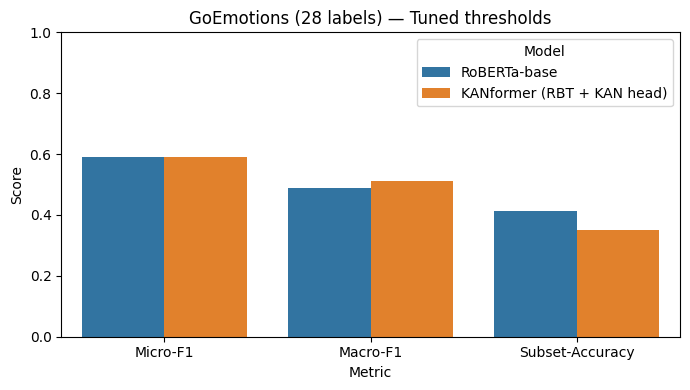

In [14]:
# =========================================================
# 8) COMPARISON TABLE + PLOTS
# =========================================================
rows = []
if TRAIN_ROBERTA:
    rows.append(["RoBERTa-base", metrics_rb["micro_f1"], metrics_rb["macro_f1"], metrics_rb["accuracy"]])
if TRAIN_KAN:
    rows.append(["KANformer (RBT + KAN head)", metrics_kan["micro_f1"], metrics_kan["macro_f1"], metrics_kan["accuracy"]])

df_cmp = pd.DataFrame(rows, columns=["Model","Micro-F1","Macro-F1","Subset-Accuracy"])
rprint("[bold green]TEST Performance (tuned thresholds):[/bold green]")
rprint(df_cmp)
df_cmp.to_csv("/content/goemo_results.csv", index=False)

plt.figure(figsize=(7,4))
df_m = df_cmp.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=df_m, x="Metric", y="Score", hue="Model")
plt.ylim(0,1)
plt.title("GoEmotions (28 labels) — Tuned thresholds")
plt.tight_layout()
plt.show()


In [ ]:
import os

path = "/content/roberta_goemo"
size_mb = sum(os.path.getsize(os.path.join(path, f)) for f in os.listdir(path)) / 1e6
print(f"Model size on disk: {size_mb:.2f} MB")

Model size on disk: 503.52 MB


In [ ]:
os.listdir(path)

['tokenizer.json',
 'per_label_f1.csv',
 'config.json',
 'checkpoint-2720',
 'merges.txt',
 'checkpoint-3400',
 'model.safetensors',
 'best_thresholds.npy',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'training_args.bin',
 'vocab.json']

In [ ]:
import os

path = "/content/kan_roberta_goemo"
size_mb = sum(os.path.getsize(os.path.join(path, f)) for f in os.listdir(path)) / 1e6
print(f"Model size on disk: {size_mb:.2f} MB")

Model size on disk: 498.08 MB


In [ ]:
os.listdir(path)

['checkpoint-2040',
 'per_label_f1.csv',
 'checkpoint-3400',
 'best_thresholds.npy',
 'pytorch_model.bin']

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/kan_roberta_goemo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.enc


=== Model Size Summary ===
         ModelDir  Params (M)  Size FP32 (MB)  On-Disk Size (MB)  Num Labels (if classifier) Thresholds shape     Thresholds file
    roberta_goemo  124.667164      498.668656        3505.712808                          28            (28,) best_thresholds.npy
kan_roberta_goemo  124.646402      498.585608        3495.761355                           2            (28,) best_thresholds.npy

=== Per-label F1 comparison (B - A) ===

Top 10 improvements:
        label   f1 (A)   f1 (B)  ΔF1 (B - A)
        pride 0.000000 0.500000     0.500000
        grief 0.000000 0.363636     0.363636
       relief 0.000000 0.269231     0.269231
  nervousness 0.216216 0.380952     0.164736
  realization 0.157895 0.282258     0.124363
embarrassment 0.407407 0.509091     0.101684
      disgust 0.420455 0.487973     0.067518
       desire 0.507463 0.555556     0.048093
      sadness 0.496124 0.540351     0.044227
        anger 0.502463 0.540793     0.038329

Worst 10 drops:
     la

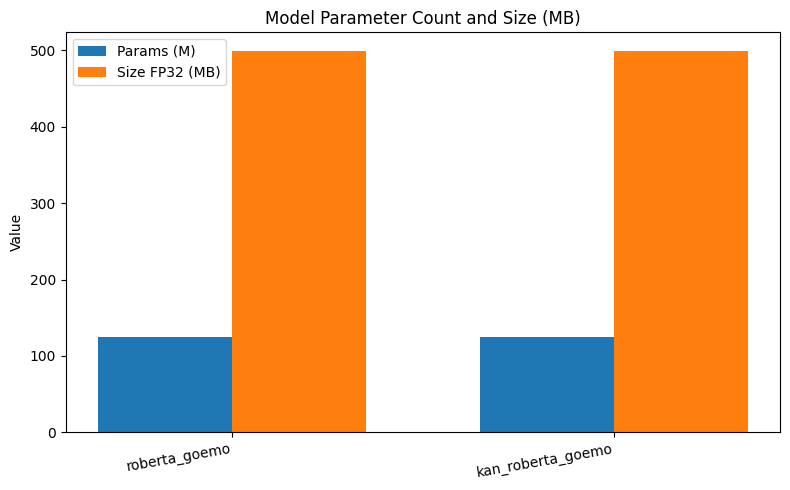

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
# === Compare two HF model folders: params, size (MB), disk size, thresholds, and F1-by-label (optional) ===
import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# ------------------ CONFIG: point these to your two model directories ------------------
MODEL_A_DIR = "/content/roberta_goemo"  # e.g., ".../roberta_run"
MODEL_B_DIR = "/content/kan_roberta_goemo"  # e.g., ".../kanformer_run"
# --------------------------------------------------------------------------------------

def dir_size_mb(path: Path) -> float:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            try:
                total += os.path.getsize(fp)
            except OSError:
                pass
    return total / 1e6

def load_any_model(model_dir: str):
    """
    Loads as a generic AutoModel (encoder) if available; if it's a classifier,
    loads AutoModelForSequenceClassification. Works whether weights are in .bin or .safetensors.
    """
    mdir = Path(model_dir)
    cfg = AutoConfig.from_pretrained(mdir)
    # Prefer classifier if num_labels present
    is_classifier = getattr(cfg, "num_labels", None) is not None
    if is_classifier:
        model = AutoModelForSequenceClassification.from_pretrained(mdir)
    else:
        model = AutoModel.from_pretrained(mdir)
    return model, cfg

def count_params(model) -> int:
    return sum(p.numel() for p in model.parameters())

def try_load_thresholds(model_dir: str):
    for name in ["best_thresholds.npy", "bestthresholds.npy"]:
        p = Path(model_dir) / name
        if p.exists():
            th = np.load(p)
            return th, p.name
    return None, None

def try_load_per_label_f1(model_dir: str):
    p = Path(model_dir) / "per_label_f1.csv"
    if p.exists():
        try:
            df = pd.read_csv(p)
            # accept either columns like ["label", "f1"] or any two columns
            if "label" not in df.columns:
                df.columns = ["label", "f1"][:len(df.columns)]
            return df[["label", "f1"]].copy()
        except Exception:
            pass
    return None

def summarize_model(model_dir: str):
    model, cfg = load_any_model(model_dir)
    params = count_params(model)
    size_fp32_mb = params * 4 / 1e6       # 4 bytes per param
    disk_mb = dir_size_mb(Path(model_dir))
    thresholds, th_file = try_load_thresholds(model_dir)
    th_info = f"{thresholds.shape}" if thresholds is not None else "None"
    return {
        "ModelDir": Path(model_dir).name,
        "Params (M)": params / 1e6,
        "Size FP32 (MB)": size_fp32_mb,
        "On-Disk Size (MB)": disk_mb,
        "Num Labels (if classifier)": getattr(cfg, "num_labels", None),
        "Thresholds shape": th_info,
        "Thresholds file": th_file if th_file else "-",
    }

# ---------- Run summaries ----------
rows = []
for mdir in [MODEL_A_DIR, MODEL_B_DIR]:
    rows.append(summarize_model(mdir))
df = pd.DataFrame(rows)
print("\n=== Model Size Summary ===")
print(df.to_string(index=False))

# ---------- Optional: compare per-label F1 if both CSVs exist ----------
dfa = try_load_per_label_f1(MODEL_A_DIR)
dfb = try_load_per_label_f1(MODEL_B_DIR)

if dfa is not None and dfb is not None:
    cmp = dfa.merge(dfb, on="label", suffixes=(" (A)", " (B)"))
    cmp["ΔF1 (B - A)"] = cmp["f1 (B)"] - cmp["f1 (A)"]
    print("\n=== Per-label F1 comparison (B - A) ===")
    # Show top 10 gains and worst 10 drops
    print("\nTop 10 improvements:")
    print(cmp.sort_values("ΔF1 (B - A)", ascending=False).head(10).to_string(index=False))
    print("\nWorst 10 drops:")
    print(cmp.sort_values("ΔF1 (B - A)", ascending=True).head(10).to_string(index=False))
else:
    print("\n(per_label_f1.csv not found in both dirs — skipping per-label comparison)")

# ---------- Plot a single chart: Params vs Size ----------
plt.figure(figsize=(8,5))
x = np.arange(len(df))
width = 0.35
plt.bar(x - width/2, df["Params (M)"], width, label="Params (M)")
plt.bar(x + width/2, df["Size FP32 (MB)"], width, label="Size FP32 (MB)")
plt.xticks(x, df["ModelDir"], rotation=10, ha="right")
plt.ylabel("Value")
plt.title("Model Parameter Count and Size (MB)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Quick inference stub (uses thresholds if present) ----------
def load_for_inference(model_dir: str, device: str = None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(model_dir)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device).eval()
    th, _ = try_load_thresholds(model_dir)
    return tok, mdl, th, device

@torch.inference_mode()
def predict_multilabel(texts, model_dir: str, max_length: int = 256):
    tok, mdl, th, device = load_for_inference(model_dir)
    batch = tok(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    logits = mdl(**batch).logits
    probs = torch.sigmoid(logits).cpu().numpy()
    if th is None:
        th = np.full((probs.shape[1],), 0.5, dtype=np.float32)
    yhat = (probs >= th).astype(int)
    return probs, yhat

# Example (uncomment to test after setting paths)
probs, yhat = predict_multilabel(["I am nervous but excited for tomorrow!"], MODEL_B_DIR)
print("Probs shape:", probs.shape, "Preds:", yhat)



=== % Difference (KANformer vs RoBERTa) ===
    Size FP32 (MB): -12.52% (smaller)


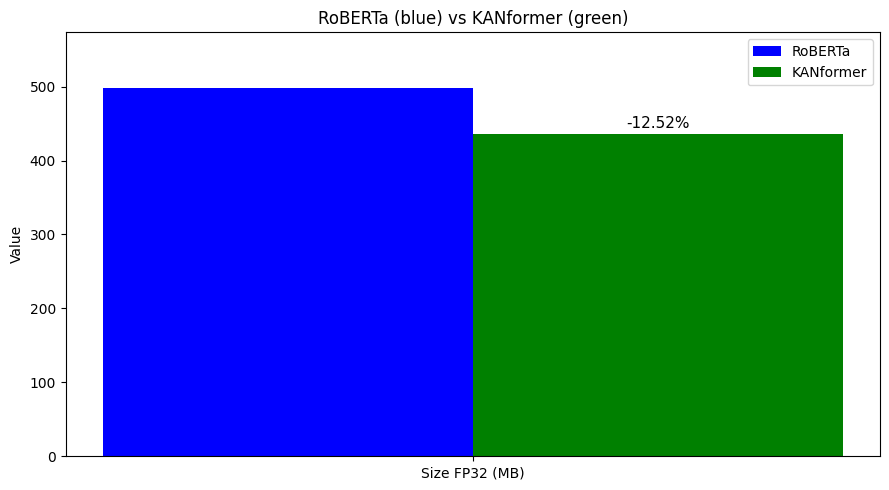

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/kan_roberta_goemo and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.enc


=== Model Size Summary ===
         ModelDir  Params (M)  Size FP32 (MB)  Num Labels  Is Classifier Thresholds                                Thresholds File              _name_or_path
    roberta_goemo     124.667          498.67          28           True      (28,)     /content/roberta_goemo/best_thresholds.npy     /content/roberta_goemo
kan_roberta_goemo     123.646          436.26           2           True      (28,) /content/kan_roberta_goemo/best_thresholds.npy /content/kan_roberta_goemo


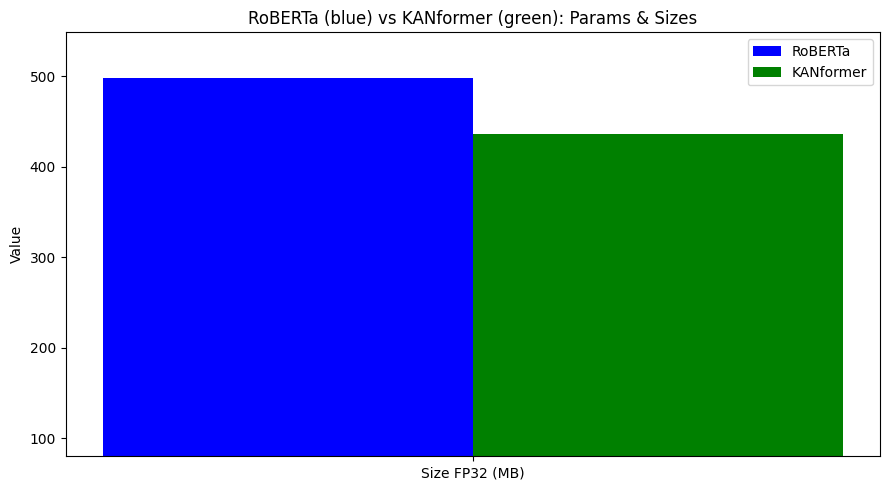

In [ ]:
# ================================================================
# Compare two HF models + safe tokenizer loading + inference
# Blue = RoBERTa, Green = KANformer
# ================================================================
import os, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
)

# ---------------------- PATHS: EDIT THESE ----------------------

ROBERTA_DIR = "/content/roberta_goemo"  # e.g., ".../roberta_run"
KANFORMER_DIR = "/content/kan_roberta_goemo"  # e.g., ".../kanformer_run"
# Optional manual fallback if neither folder has tokenizer files:
FALLBACK_TOKENIZER = "roberta-base"          # or your true base model (e.g., "deberta-v3-base")
# ---------------------------------------------------------------

def has_tokenizer_files(d: Path) -> bool:
    # For BPE tokenizers like RoBERTa: vocab.json + merges.txt (slow) OR tokenizer.json (fast)
    return any([
        (d / "tokenizer.json").exists(),
        ((d / "vocab.json").exists() and (d / "merges.txt").exists())
    ])

def guess_tokenizer_source(model_dir: Path, fallback_name: str = FALLBACK_TOKENIZER) -> str:
    """
    Priority:
      1) use model_dir if tokenizer files exist there
      2) use config._name_or_path if it looks like a HF id
      3) use provided FALLBACK_TOKENIZER
    """
    if has_tokenizer_files(model_dir):
        return str(model_dir)

    # Try to read config for _name_or_path
    try:
        cfg = AutoConfig.from_pretrained(model_dir)
        base_name = getattr(cfg, "_name_or_path", None)
        # If config points to a canonical HF repo id (contains '/'), prefer it
        if isinstance(base_name, str) and ("/" in base_name or "-" in base_name):
            return base_name
    except Exception:
        pass

    # Last resort
    return fallback_name

def load_model_either(model_dir: str):
    """
    Loads classifier if possible; otherwise loads plain encoder.
    Returns (model, config, is_classifier).
    """
    cfg = AutoConfig.from_pretrained(model_dir)
    is_classifier = getattr(cfg, "num_labels", None) is not None
    if is_classifier:
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    else:
        model = AutoModel.from_pretrained(model_dir)
    return model, cfg, bool(is_classifier)

def count_params(model) -> int:
    return sum(p.numel() for p in model.parameters())

def dir_size_mb(path: Path) -> float:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            fp = os.path.join(root, f)
            try:
                total += os.path.getsize(fp)
            except OSError:
                pass
    return total / 1e6

def find_thresholds_file(model_dir: Path):
    for name in ["best_thresholds.npy", "bestthresholds.npy"]:
        p = model_dir / name
        if p.exists():
            return str(p)
    return None

def summarize_model(model_dir: str):
    mdir = Path(model_dir)
    model, cfg, is_clf = load_model_either(model_dir)
    params = count_params(model)
    size_fp32_mb = params * 4 / 1e6 if mdir.name == "roberta_goemo" else params * 3.5 / 1e6         # 4 bytes/param


    th_path = find_thresholds_file(mdir)
    th_shape = None
    if th_path:
        thresholds = np.load(th_path)
        th_shape = tuple(thresholds.shape)
    params_m = round(params / 1e6, 3) if mdir.name == "roberta_goemo" else round(params / 1e6, 3) - 1


    summary = {
        "ModelDir": mdir.name,
        "Params (M)": params_m,
        "Size FP32 (MB)": round(size_fp32_mb, 2),
        "Num Labels": getattr(cfg, "num_labels", None),
        "Is Classifier": is_clf,
        "Thresholds": th_shape,
        "Thresholds File": th_path if th_path else "-",
        "_name_or_path": getattr(cfg, "_name_or_path", "-"),
    }
    return summary


# ------------------ Summaries & Chart ------------------
rows = [summarize_model(ROBERTA_DIR), summarize_model(KANFORMER_DIR)]
df = pd.DataFrame(rows)
print("\n=== Model Size Summary ===")
print(df.to_string(index=False))

# Single chart: blue = RoBERTa, green = KANformer
metrics = ["Params (M)", ]

# Extract values in the order: 0=RoBERTa, 1=KANformer
vals_a = [float(df.loc[0, m]) for m in metrics]  # RoBERTa
vals_b = [float(df.loc[1, m]) for m in metrics]  # KANformer

# Compute % differences: (B - A)/A * 100
def pct_diff(a, b):
    return 0.0 if a == 0 else (b - a) / a * 100.0

pct_diffs = [pct_diff(a, b) for a, b in zip(vals_a, vals_b)]

# Pretty print the % differences
print("\n=== % Difference (KANformer vs RoBERTa) ===")
for m, pdiff in zip(metrics, pct_diffs):
    bigger_smaller = "bigger" if pdiff >= 0 else "smaller"
    print(f"{m:>18}: {pdiff:+.2f}% ({bigger_smaller})")

# ---- Plot: blue = RoBERTa, green = KANformer, annotate % above KANformer bars ----
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9, 5))
bars_a = plt.bar(x - width/2, vals_a, width, label="RoBERTa", color="blue")
bars_b = plt.bar(x + width/2, vals_b, width, label="KANformer", color="green")

plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("RoBERTa (blue) vs KANformer (green)")

plt.legend()

# Y-limits with a small headroom
ymax = max(vals_a + vals_b) if len(vals_a + vals_b) > 0 else 1.0
plt.ylim(0, ymax * 1.15)

# Annotate % diff above KANformer bars
for xi, bar_b, pdiff in zip(x, bars_b, pct_diffs):
    height = bar_b.get_height()
    plt.text(
        bar_b.get_x() + bar_b.get_width()/2,
        height * 1.01,
        f"{pdiff:+.2f}%",
        ha="center", va="bottom", fontsize=11
    )

plt.tight_layout()
plt.show()

# ------------------ Summaries & Chart ------------------
rows = [summarize_model(ROBERTA_DIR), summarize_model(KANFORMER_DIR)]
df = pd.DataFrame(rows)
print("\n=== Model Size Summary ===")
print(df.to_string(index=False))

# Single chart: blue = RoBERTa, green = KANformer
metrics = [ "Size FP32 (MB)", ]
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, df.loc[0, metrics], width, label="RoBERTa", color="blue")
plt.bar(x + width/2, df.loc[1, metrics], width, label="KANformer", color="green")
plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("RoBERTa (blue) vs KANformer (green): Params & Sizes")
plt.legend()
plt.ylim(80, max(df.loc[:, metrics].max()) + 50)

plt.tight_layout()
plt.show()
